In [30]:
import json
from arcgis.features import FeatureLayer
from arcgis.geometry import Geometry
from shapely.geometry import Polygon
import shapely.wkt
import pyproj
from shapely.ops import transform
from functools import partial
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import contextily as ctx

In [2]:
from arcgis.gis import GIS
import geopandas as gpd
from shapely.ops import unary_union
from arcgis.geometry import Geometry

gis = GIS()
app_id = "65f0aa6db8124aeda54e1f33c5dfe66c"

app_item = gis.content.get(app_id)
app_item

<Item title:"AEM Profile Attachment Viewer" type:Web Mapping Application owner:Katherine.Dlubac@water.ca.gov_DWR>

In [3]:
app_data = app_item.get_data()

In [4]:
web_map_id = "e8b4e84bda804990881cd49d28ac1360"
web_map_item = gis.content.get(web_map_id)

if web_map_item.type != "Web Map":
    raise ValueError("The provided item is not a Web Map.")

web_map = web_map_item.get_data()
layers = web_map.get("operationalLayers", [])

for layer in layers:
    layer_title = layer.get("title", "Untitled Layer")
    layer_id = layer.get("id", "No ID")
    layer_url = layer.get("url", "No URL")
    print(f"Layer Title: {layer_title}")
    print(f"Layer ID: {layer_id}")
    print(f"Layer URL: {layer_url}")
    print("-" * 40)

Layer Title: Statewide AEM Survey Electrical Resistivity Slices and Intervals
Layer ID: 18a0993f885-layer-9
Layer URL: https://services.arcgis.com/aa38u6OgfNoCkTJ6/arcgis/rest/services/Poly_Int_Idw_AEM_1_8_merged/FeatureServer/924
----------------------------------------
Layer Title: AEM Electrical Resistivity Profiles
Layer ID: 18dfabf91c1-layer-36
Layer URL: No URL
----------------------------------------
Layer Title: Statewide AEM Survey Coarse Fraction Depth Slices and Average
Layer ID: 18eaff17d0c-layer-36
Layer URL: https://services.arcgis.com/aa38u6OgfNoCkTJ6/arcgis/rest/services/Statewide_AEM_Survey_Coarse_Fraction_Depth_Slices_and_Average/FeatureServer/0
----------------------------------------
Layer Title: AEM Coarse Fraction Profiles
Layer ID: 18dfae96507-layer-67
Layer URL: No URL
----------------------------------------
Layer Title: StatewideAEMSurveyAreas
Layer ID: 18eca08249b-layer-36
Layer URL: https://services.arcgis.com/aa38u6OgfNoCkTJ6/arcgis/rest/services/StatewideA

In [5]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)

In [6]:
import json
from arcgis.features import FeatureLayer
from arcgis.geometry import Geometry, Envelope
import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import box
from shapely.geometry import shape

url = "https://services.arcgis.com/aa38u6OgfNoCkTJ6/arcgis/rest/services/Statewide_AEM_Survey_Coarse_Fraction_Depth_Slices_and_Average/FeatureServer/0"
layer = FeatureLayer(url)

layer_info = layer.properties
layer_sr = layer_info.spatialReference.wkid if hasattr(layer_info, 'spatialReference') else 3309
print(f"Layer's spatial reference WKID: {layer_sr}")

filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']
minx, miny, maxx, maxy = filtered_gdf.total_bounds

if gdf.crs != f"EPSG:{layer_sr}":
    bbox_gdf = gpd.GeoDataFrame(geometry=[box(minx, miny, maxx, maxy)], crs=gdf.crs)
    bbox_gdf = bbox_gdf.to_crs(f"EPSG:{layer_sr}")
    minx, miny, maxx, maxy = bbox_gdf.total_bounds

envelope = {
    "xmin": minx,
    "ymin": miny,
    "xmax": maxx,
    "ymax": maxy,
    "spatialReference": {"wkid": layer_sr}
}

geom = Geometry(envelope)

query_result = layer.query(
    geometry=geom,
    spatial_relationship="esriSpatialRelIntersects",
    out_fields="*",
    return_geometry=True  # Make sure to request geometry
)

Layer's spatial reference WKID: 3309


In [7]:
result_df = query_result.sdf
result_gdf = gpd.GeoDataFrame(result_df, geometry='SHAPE', crs=f"EPSG:{layer_sr}")
result_gdf = result_gdf.to_crs(filtered_gdf.crs)

In [8]:
combined_polygon = unary_union(filtered_gdf.geometry)

In [9]:
result_gdf = gpd.clip(result_gdf, combined_polygon)

In [10]:
result_gdf[result_gdf.Interval_Type == 'Average, 0-15m'].PercentCoarse.unique()

<StringArray>
[ '70-80',  '80-90',  '50-60',  '60-70',  '40-50', '90-100',  '30-40',
   '0-10',  '20-30',  '10-20']
Length: 10, dtype: string

In [11]:
import pickle
with open("grid_large_std.pkl", "rb") as f:
    grid = pickle.load(f)

In [12]:
grid_mini = grid[['geometry']]

In [13]:
import geopandas as gpd
from shapely.geometry import Polygon
import pyproj

def check_boxes_within_polygons(grid_points_gdf, polygons_gdf, box_size=1000):
    """
    Check if 1km boxes centered on grid points fall within any polygon.
    
    Args:
        grid_points_gdf: GeoDataFrame with point geometries (centers of boxes)
        polygons_gdf: GeoDataFrame with polygon geometries to check against
        box_size: Size of square box in meters (default 1000m)
    
    Returns:
        GeoDataFrame with original points and new column indicating containment
    """
    # Create temporary copies to avoid modifying originals
    temp_grid = grid_points_gdf.copy()
    temp_polygons = polygons_gdf.copy()
    
    # Determine appropriate UTM CRS automatically
    centroid = temp_grid.geometry.unary_union.centroid
    utm_crs = f"EPSG:{32600 + int((centroid.x + 180)/6 + 1)}"  # Auto UTM zone
    if centroid.y < 0:  # Southern hemisphere
        utm_crs = f"EPSG:{32700 + int((centroid.x + 180)/6 + 1)}"
    
    # Convert to UTM (temporary CRS for accurate distance measurements)
    temp_grid = temp_grid.to_crs(utm_crs)
    temp_polygons = temp_polygons.to_crs(utm_crs)
    
    # Create boxes around each point in temporary GeoDataFrame
    half_size = box_size / 2
    boxes = temp_grid.geometry.apply(
        lambda p: Polygon([
            (p.x - half_size, p.y - half_size),
            (p.x + half_size, p.y - half_size),
            (p.x + half_size, p.y + half_size),
            (p.x - half_size, p.y + half_size)
        ])
    )
    
    # Create temporary GeoDataFrame for the boxes
    temp_boxes = gpd.GeoDataFrame(
        geometry=boxes,
        crs=temp_grid.crs
    )
    
    # Perform spatial join to find contained boxes
    joined = gpd.sjoin(
        temp_boxes, 
        temp_polygons, 
        how='left', 
        predicate='within'
    )
    
    # Add results back to original CRS (if different from UTM)
    result = grid_points_gdf.copy()
    result['is_contained'] = ~joined['index_right'].isna()
    result['box_geometry'] = boxes.to_crs(grid_points_gdf.crs)
    
    return result

In [27]:
depth_slices = result_gdf[result_gdf.Interval_Type == "Depth Slice"].copy()

In [15]:
mask_overlap = grid_mini.geometry.intersects(depth_slices.union_all())

In [16]:
aem_grid = grid_mini[mask_overlap].copy()

In [44]:
def get_midpoint(interval_str):
    """
    Convert a string like "0-10" into its midpoint float, e.g. 5.0
    """
    low, high = interval_str.split('-')
    return (float(low) + float(high)) / 2.0

depth_slices['PercentCoarse_mid'] = depth_slices['PercentCoarse'].apply(get_midpoint)
intervals = [
    (15, 30), (30, 45), (45, 60), (60, 75),
    (75, 90), (90, 105), (105, 120), (120, 135), (135, 150)
]

joined = aem_grid.sjoin(depth_slices, how='left', predicate='intersects').dropna()

def get_weighted_coarse_for_intervals(group):
    """
    For a single aem_grid cell (group of depth_slices), compute
    the depth-weighted average of PercentCoarse_mid for each 15 m slice.
    """
    results = {}
    
    for (start, end) in intervals:
        interval_len = end - start
        sub = group[
            (group['Depth_Top_Interval_m'] < end) &
            (group['Depth_Bottom_Interval_m'] > start)
        ]
        
        if len(sub) == 0:
            results[f'PercentCoarse_{start}_{end}'] = np.nan
            continue
        
        weighted_sum = 0.0
        coverage_sum = 0.0
        
        for idx, row in sub.iterrows():
            overlap_top = max(start, row['Depth_Top_Interval_m'])
            overlap_bot = min(end,   row['Depth_Bottom_Interval_m'])
            overlap = overlap_bot - overlap_top
            
            if overlap > 0:
                frac = overlap / interval_len  # fraction of the 15 m interval
                weighted_sum += row['PercentCoarse_mid'] * frac
                coverage_sum += frac
        if coverage_sum == 0:
            results[f'PercentCoarse_{start}_{end}'] = np.nan
        else:
            weighted_avg = weighted_sum / coverage_sum
            results[f'PercentCoarse_{start}_{end}'] = weighted_avg
    
    return pd.Series(results)

per_grid_averages = joined.groupby(level=0).apply(get_weighted_coarse_for_intervals)

aem_grid_with_coarse = aem_grid.join(per_grid_averages)

In [50]:
with open('aem_15_150_grid.pkl', 'wb') as f:
    pickle.dump(aem_grid_with_coarse, f)

In [20]:
slice_75_90 = result_gdf[(result_gdf.Depth_Bottom_Interval_m > 75) & (result_gdf.Depth_Top_Interval_m < 90)].copy()

In [21]:
slice_75_90["mids"] = slice_75_90.PercentCoarse.apply(lambda x: int(x.split("-")[1]) - 5)

<Axes: >

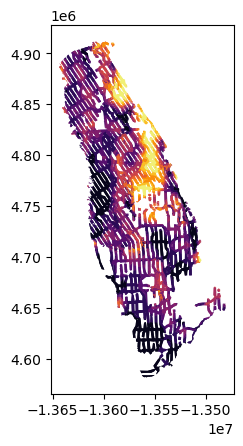

In [24]:
slice_75_90.plot("mids", cmap="inferno", vmin=0, vmax=100)

7it [00:11,  1.65s/it]


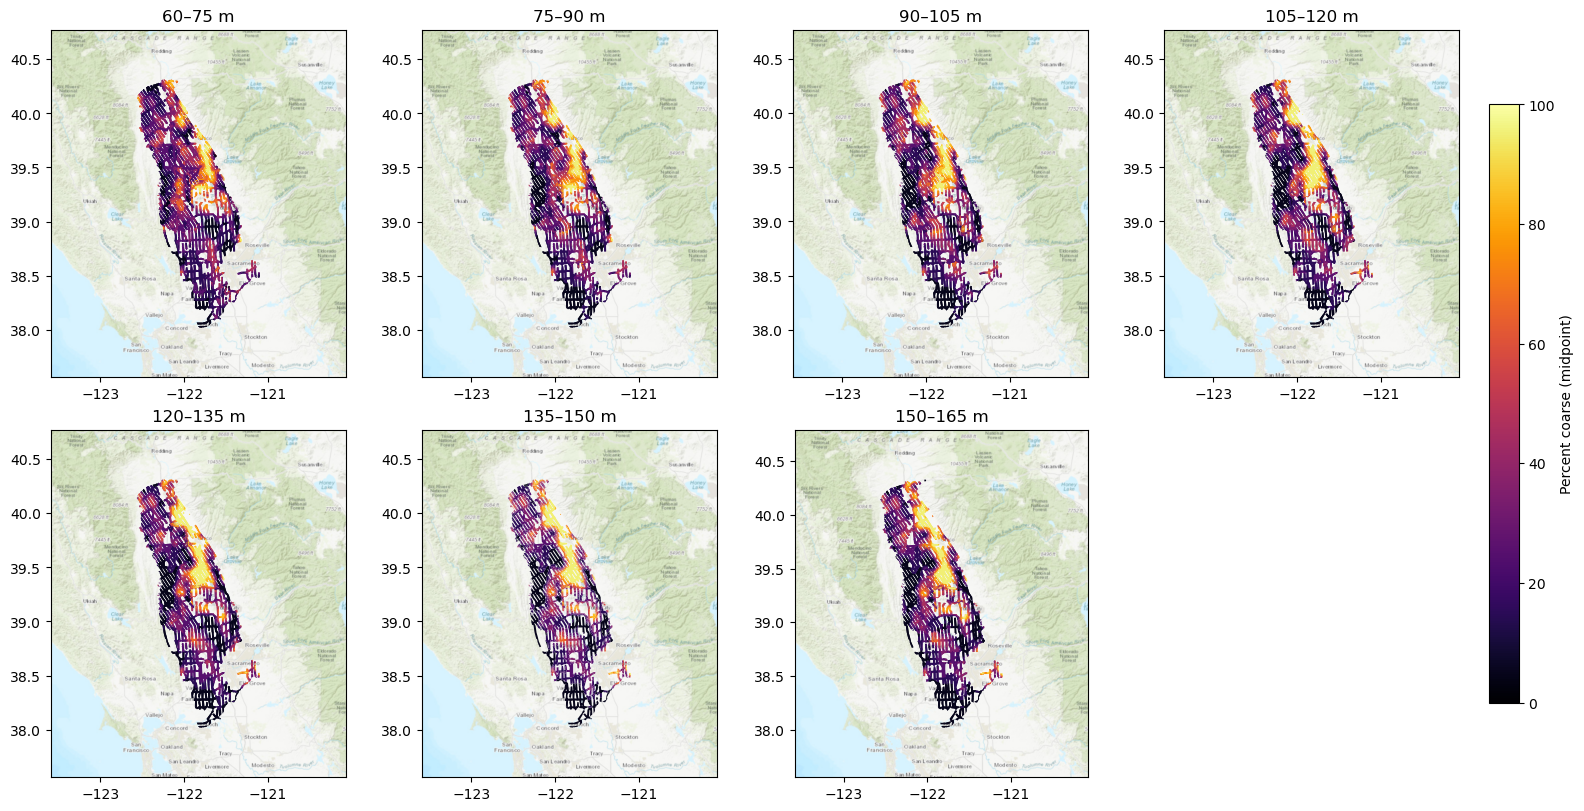

In [36]:
intervals = [(i, i + 15) for i in np.arange(60, 165, 15)]
n = len(intervals)

# layout: 4 columns (you can adjust)
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(ncols * 4, nrows * 4),
                         constrained_layout=True)
axes = axes.flatten()

for ax, (start, end) in tqdm(zip(axes, intervals)):
    sl = result_gdf[
        (result_gdf.Depth_Bottom_Interval_m > start) &
        (result_gdf.Depth_Top_Interval_m    < end)
    ].copy()
    sl["mids"] = sl.PercentCoarse.apply(lambda x: int(x.split("-")[1]) - 5)
    sl = sl.to_crs(epsg=4326)
    xmin, ymin, xmax, ymax = sl.total_bounds
    x_buffer = (xmax - xmin) * 0.7
    y_buffer = (ymax - ymin) * 0.2
    ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
    ax.set_ylim(ymin - y_buffer, ymax + y_buffer)
    sl.plot(column="mids", ax=ax, cmap="inferno",
            vmin=0, vmax=100, legend=False)
    ax.set_title(f"{start}–{end} m")
    ctx.add_basemap(
        ax,
        source=ctx.providers.Esri.WorldTopoMap,
        crs=sl.crs,
        attribution=False
    )

for ax in axes[len(intervals):]:
    fig.delaxes(ax)

cax = fig.colorbar(
    plt.cm.ScalarMappable(cmap="inferno", norm=plt.Normalize(0, 100)),
    ax=axes.tolist(), orientation="vertical", fraction=0.05, pad=0.02, shrink=0.8
)
cax.set_label("Percent coarse (midpoint)")
plt.show()